In [0]:
!pip install pmdarima

     |████████████████████████████████| 921kB 4.8MB/s 
     |████████████████████████████████| 24.8MB 83.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [0]:
scaler = MinMaxScaler()
df_crawl = pd.read_csv("crawl.csv",parse_dates=['date'], index_col='date')
df_active = pd.read_csv('active.csv',parse_dates=['date'], index_col='date')
df_sum_crawl = df_crawl['2016-08-01':'2019-07-31'].resample('M').sum()
df_sum_active = df_active['2016-08-01':'2019-07-31'].resample('M').sum()
data = pd.concat([df_sum_crawl['crawl unique'],df_sum_active['active unique']],axis=1)
data[['crawl unique', 'active unique']] = scaler.fit_transform(data[['crawl unique', 'active unique']])


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-64.833, BIC=-55.507, Fit time=0.186 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-60.192, BIC=-56.195, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-59.124, BIC=-53.795, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-59.849, BIC=-54.520, Fit time=0.071 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-61.232, BIC=-53.239, Fit time=0.234 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-63.477, BIC=-52.819, Fit time=0.352 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-65.076, BIC=-57.083, Fit time=0.235 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-58.012, BIC=-51.351, Fit time=0.130 seconds
Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-65.149, BIC=-55.823, Fit time=0.248 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 0, 0, 1);

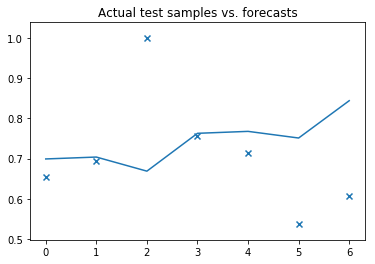

In [13]:
# #############################################################################
# Load the data and split it into separate pieces

train, test = data[:29], data[29:]

# Fit a simple auto_arima model
forecast_active_pages = pm.auto_arima(y=train['active unique'], exogenous=train["crawl unique"].values.reshape(-1, 1), trace=1,
                    seasonal=True,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=True)

print(forecast_active_pages.summary())

# #############################################################################
# Plot actual test vs. forecasts:
x = np.arange(test['active unique'].shape[0])
plt.scatter(x, test['active unique'], marker='x')
plt.plot(x, forecast_active_pages.predict(exogenous=test['crawl unique'].values.reshape(-1, 1),n_periods=test.shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show();

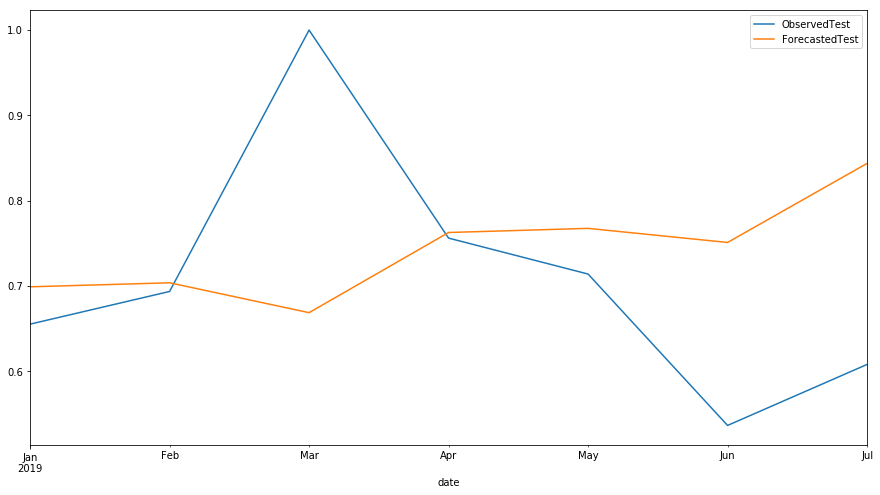

In [15]:
predicts = pd.DataFrame(forecast_active_pages.predict(exogenous=test['crawl unique'].values.reshape(-1, 1),n_periods=test.shape[0]), index = test.index)
pd.concat([test['active unique'],predicts],axis=1).plot(figsize=(15,8))
L=plt.legend()
L.get_texts()[0].set_text('ObservedTest')
L.get_texts()[1].set_text('ForecastedTest')